# Processing and narrating a footbal video with GPT's visual capabilities and the TTS API

In this notebook i will use the new GPT-4 Vision Preview endpoint and the TTS API to process a football video and narrate it with the style of the famous British narrator Peter Drury.

This is a very simple example of what can be done using the new GPT-4 Vision Preview endpoint and the TTS API. The only purpose of this work is to show the capabilities of the new functionalities.

This work was inspired by:

- ["Processing and narrating a video with GPT's visual capabilities and the TTS API" by Kai Chen @OpenAI](https://cookbook.openai.com/examples/gpt_with_vision_for_video_understanding)
- ["GPT-4V + TTS = AI Sports narrator" by Gonzalo Espinoza Graham](https://twitter.com/geepytee/status/1721705524176257296)


#### Imports

In [8]:
from IPython.display import display, Image, Audio

import cv2  # We're using OpenCV to read video
import base64
import time
from openai import OpenAI
import os
import requests
from dotenv import load_dotenv

load_dotenv()

True

#### Frame extraction
First we use OpenCV to extract frames from a video

In [9]:
video = cv2.VideoCapture("data/world-cup-final.mp4")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

1600 frames read.


Display frames to make sure we've read them in correctly:

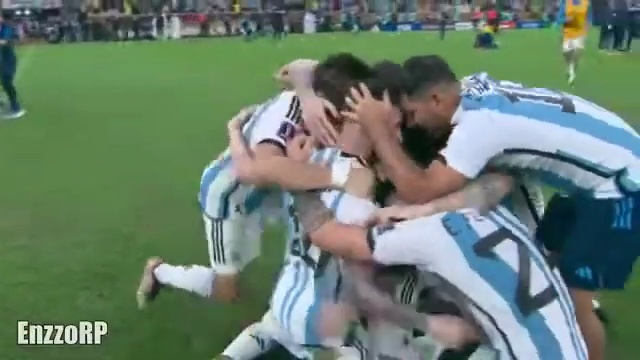

In [10]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)

#### Using the GPT-4 Vision Preview endpoint to generate a description of the video
Once we have the video frames we craft our prompt and send a request to GPT (Note that we don't need to send every frame for GPT to understand what's going on):

In [11]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames from a video that I want to upload. Generate a compelling description that I can upload along with the video.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::50]), # Only send every 50th frame in order to stay under the token rate limit
        ],
    },
]
client = OpenAI(api_key=os.environ['OPENAI_API_KEY'])
result = client.chat.completions.create(model='gpt-4-vision-preview', messages=PROMPT_MESSAGES, max_tokens=200)
print(result.choices[0].message.content)

"Feel the passion, the intensity, and the unbridled joy of soccer in this electrifying video! Witness the dramatic ups and downs as talented players clad in iconic striped jerseys navigate through challenges and triumphs on the field. Experience every moment of tension leading up to the crucial penalty shot and the ensuing celebration that captures the spirit of the beautiful game. Are you ready to be part of the action? Join us for a rollercoaster ride of emotions and unforgettable soccer moments!"


#### Generating a script and voiceover with the TTS API
Now let's create a voiceover for this video in the style of Peter Drury. Using the same video frames we prompt GPT to give us a short script:

In [12]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            # Do not give the model any information about the video besides that the teams are Argentina and France
            "These are frames of video featuring the Argentina and France football teams. Create a short voiceover script in Spanish in the style of the famous British sports commentator Peter Drury. Only include the narration, do not include extra notes.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::50]),
        ],
    },
]

result = client.chat.completions.create(model='gpt-4-vision-preview', messages=PROMPT_MESSAGES, max_tokens=500)
print(result.choices[0].message.content)

En un teatro de sueños, donde la pasión y la historia danzan al son del balompié, Argentina y Francia se batieron en un duelo no solo de habilidades, sino de corazones palpitantes y esperanzas de gloria. Allí está él, el maestro de las emociones, aquél que con un toque transforma el cuero en oro, liderando a sus compañeros con la mirada fija en la eternidad. Los franceses, dignos rivales, aguardan con respeto y determinación, pues saben que la batalla que se avecina será una para los anales de la historia.

Y entonces, corta el silencio el estruendo del estadio; un murmullo se convierte en rugido y en el centro del universo futbolístico, un balón, tan inerte como cargado de destinos. La presión, una compañera más en el verde césped, pero los héroes no conocen de temores. Un paso al frente, un suspiro compartido con millones, la carrera, el impacto... ¡Y el balón que besa la red como un viejo amante! Explota el júbilo, se desbordan las pasiones. Los abrazos son el lenguaje universal, y 

Now we can pass the script to the TTS API where it will generate an mp3 of the voiceover:

In [13]:
response = requests.post(
    "https://api.openai.com/v1/audio/speech",
    headers={
        "Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}",
    },
    json={
        "model": "tts-1",
        "input": result.choices[0].message.content,
        "voice": "fable",
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk
Audio(audio)

In [14]:
# Download the audio file to /data folder
with open("data/world-cup-final.mp3", "wb") as f:
    f.write(audio)

The final audio was cut and inserted into the original video using iMovie to fit the video timming correctly. This is the final result.